# Template Matching using NCC and PCE (Peak to Correlation Energy)

In [1]:
from skimage.io import imread
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as patches
from scipy.signal import correlate2d, correlate

In [2]:
orig_img = imread('lena.png')
orig_img = rgb2grey(orig_img)

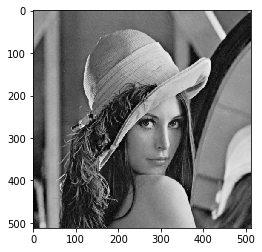

In [3]:
plt.imshow(orig_img, cmap='gray')

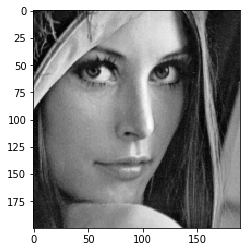

In [4]:
face = orig_img[210:410,210:400]
plt.imshow(face, cmap='gray')

## Calculate NCC (Normalized Cross Correlation) matrix
**Note:** Since no further transformation have been applied on the face image, there should be at least one entry where NCC is 1.

In [8]:
def ncc(img, kernel, shift=(0,0)):
    
    shift_row, shift_col = shift
    
    mean_kernel = np.mean(kernel)
    zero_shifted_kernel = kernel - mean_kernel
     
    img_patch = img[shift_row:shift_row+kernel.shape[0],shift_col:shift_col+kernel.shape[1]]
    mean_img_patch = np.mean(img_patch)
    zero_shifted_img_patch = img_patch - mean_img_patch

    pow_zero_shifted_img_patch = zero_shifted_img_patch * zero_shifted_img_patch
    pow_zero_shifted_kernel = zero_shifted_kernel * zero_shifted_kernel

    numerator = (zero_shifted_img_patch * zero_shifted_kernel).sum()
    denominator = np.sqrt(pow_zero_shifted_img_patch.sum() * pow_zero_shifted_kernel.sum())

    return numerator / denominator

def circular_ncc(img, kernel):
    
    ncc_matrix = np.zeros(img.shape)
    
    for shift_row in range(img.shape[0]):
        for shift_col in range(img.shape[1]):
            shifted_img = np.roll(img, -shift_col, axis=1)
            shifted_img = np.roll(shifted_img, -shift_row, axis=0)
            ncc_matrix[shift_row][shift_col] = ncc(shifted_img, kernel)
    return ncc_matrix

In [9]:
cc_matrix = circular_ncc(orig_img,face)
print(cc_matrix)

[[-0.09271381 -0.09720313 -0.10141722 ... -0.08567971 -0.08771174
  -0.08967603]
 [-0.09592553 -0.10056137 -0.10546497 ... -0.08786043 -0.09027169
  -0.09265147]
 [-0.09925575 -0.10439117 -0.10980485 ... -0.09003855 -0.09290167
  -0.0954775 ]
 ...
 [-0.08126241 -0.08608458 -0.09012322 ... -0.07703054 -0.07797982
  -0.07891499]
 [-0.0848465  -0.08942748 -0.09355654 ... -0.0797559  -0.08112243
  -0.08238279]
 [-0.08880415 -0.09336552 -0.09747492 ... -0.08272244 -0.08445993
  -0.0861064 ]]


## Finally, we also nicely visualize our NCC matrix as 3D plot 

In [37]:
def plot_3d(matrix):
    x = []
    y = []
    z = []

    for (i,j), v in np.ndenumerate(matrix):
        x.append(i)
        y.append(j)
        z.append(v)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x,y,z, cmap=plt.cm.plasma, linewidth=0.2)
    #ax.set_zlim(-1., 1.)
    plt.show()

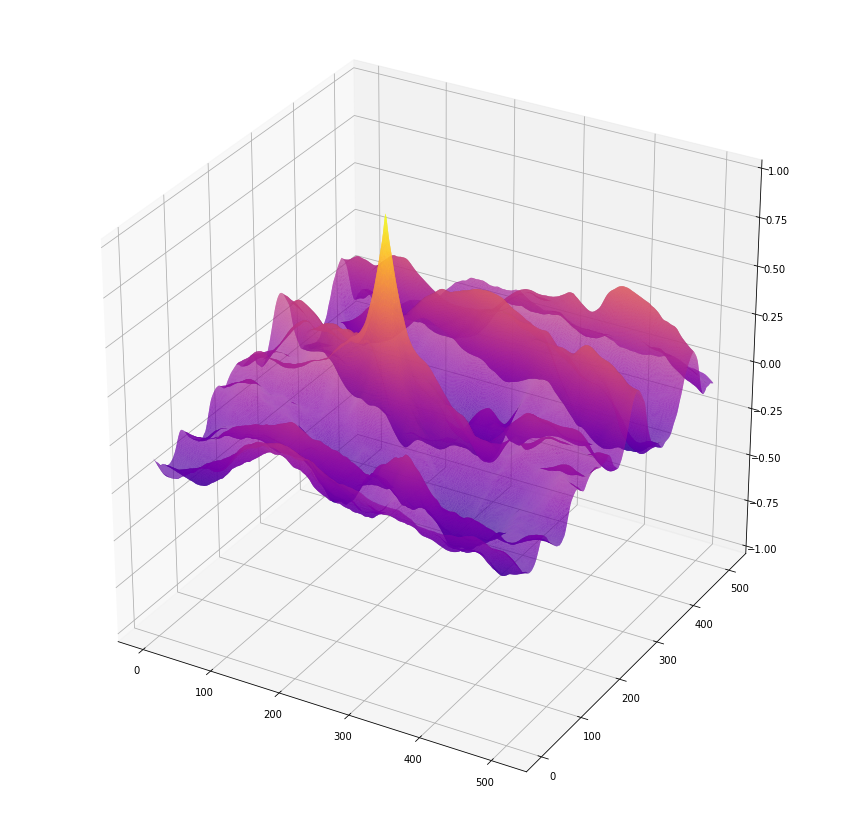

In [11]:
plot_3d(cc_matrix)

## Extract value and position of max peak

In [10]:
shift_y, shift_x = np.unravel_index(cc_matrix.argmax(), cc_matrix.shape)
print("Peak Location: %i / %i" % (shift_x, shift_y))
print("NCC Score: %f" % cc_matrix[shift_y][shift_x])

Peak Location: 210 / 210
NCC Score: 1.000000


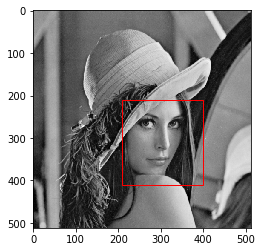

In [11]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(orig_img, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((shift_x,shift_y), face.shape[1], face.shape[0], linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## PCE (Peak to Correlation Energy)

**PCE:** <br/>
Template matching requires us to find the location in the template image that maximizes the (Normalized) Cross Entropy. Also, we prefer characteristic locations. Characteristic in a way that shifting the patch away from the best location will immediately have a strong impact on the CC (CC decreases). In other words, we are looking for locations where the CC surface is not flat.

Peak to Correlation Energy (PCE) is a measure to identify peaks. Generally speaking, we can consider a peak as something that is higher than something else (or higher than the average). The PCE score tries to measure the height of a certain point by dividing the squared correlation with the average energy in its surrounding. The maximum ratio is what we call PCE.

$PCE = \frac{c^2(x_{peak},y_{peak})}{E_{avg}}$

where $E_{avg} = \frac{1}{NM} \sum_{x,y \notin \text{Peak Area}} |c^2(x,y)|^2$

**Note:** N,M is the template size

Furthermore, we can conclude that if we **subtract the mean** when computing the CC, the PCE is the squared correlation divided by **sample variance of the circular cross-correlation**.

$PCE = \frac{c^2(x_{peak},y_{peak})}{\frac{1}{NM-\text{Kernel size}} c^2(x,y)}$

In [41]:
def pce(matrix):
    
    squared_m = matrix*matrix
     
    # Computing the average energy of the surrounding area can be easily done by correlating the image
    # with a kernel that has the size of the original image. Since the peak area should not contribute to 
    # the average energy, we set the top-left pixels of our kernel matrix to 0.
    kernel = np.full(squared_m.shape, 1/(squared_m.shape[0]*squared_m.shape[0]-11*11))
    kernel[0:11,0:11] = 0
    
    # Note: 
    # - "Wrap" to enforce circular boundary conditions
    # - "Same" to preserve the original size. Furthermore, the filter gets center on the image.
    #   This is very important since we want to consider the neighbourhood AROUND the peak.
    avg_corr_plane_energy = correlate2d(squared_m, kernel, mode='same', boundary='wrap')
    
    pce = squared_m / avg_corr_plane_energy
    
    # Additional information:
    # Correlate / Correlate2d (WITHOUT mode "same")
    # These functions do NOT "center" the filter on the image. Hence, we only consider neighbours
    # on the right hand side of the peak. To solve this issue we can simply shift the final PCE matrix.
    # 1D example:
    # Signal: 1 2 1    Kernel: 1 1 1  ==> Output of correlate (with zero padding): 1 3 4 3 1
    # Expected result: 3 4 3 
    # pce = np.roll(pce,-5, axis=1)
    # pce = np.roll(pce,-5, axis=0)
    
    return pce

In [42]:
pce_matrix = pce(cc_matrix)
print(pce_matrix)
print(pce_matrix.shape)

[[0.33689143 0.37031735 0.40313115 ... 0.28767614 0.30149729 0.31516548]
 [0.36063686 0.39634747 0.43595257 ... 0.30250746 0.31935398 0.33642746]
 [0.38611175 0.4271112  0.47256892 ... 0.3176928  0.33823366 0.35726388]
 ...
 [0.25880767 0.29044402 0.31834353 ... 0.23252321 0.23830122 0.24406195]
 [0.28214141 0.31343995 0.34306076 ... 0.24926926 0.2578968  0.26598418]
 [0.30907705 0.34165368 0.37239917 ... 0.26815895 0.27955521 0.29057304]]
(512, 512)


In [43]:
shift_y, shift_x = np.unravel_index(pce_matrix.argmax(), pce_matrix.shape)
print("PCE Peak Location: %i / %i" % (shift_x, shift_y))
print("PCE Score: %f" % pce_matrix[shift_y][shift_x])

PCE Peak Location: 210 / 210
PCE Score: 39.174895


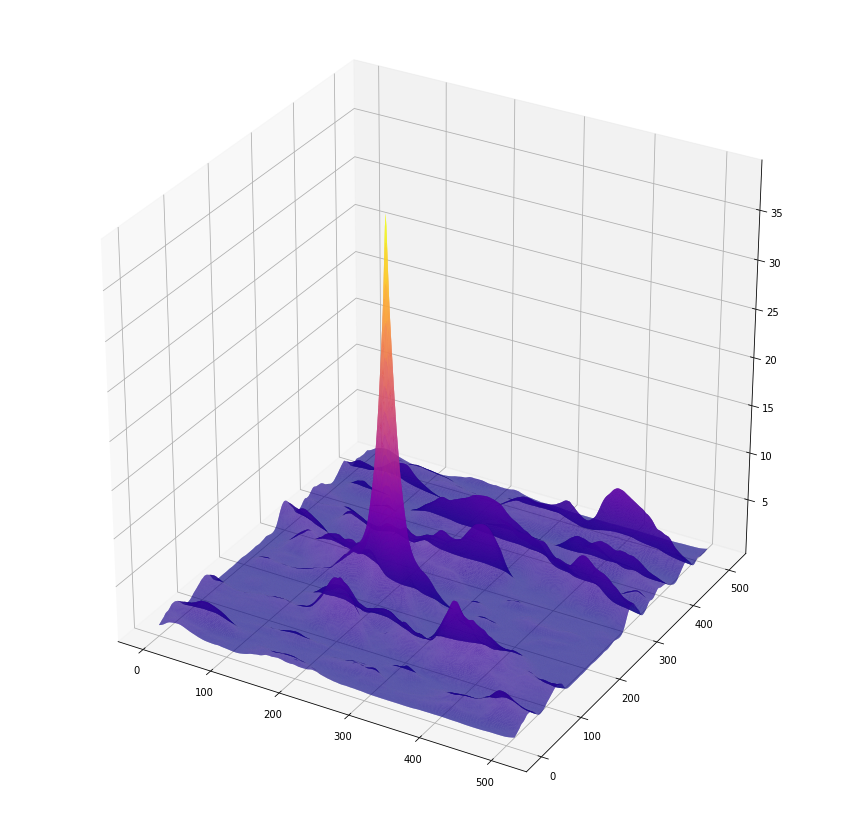

In [44]:
plot_3d(pce_matrix)